In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [34]:
df = pd.read_excel("/content/drive/MyDrive/Data/Extracted n grams 1000.xlsx")
df.shape

(1000, 13209)

In [35]:
# from sklearn.utils import shuffle
# df = shuffle(df)
# df = df[:200]

In [36]:
df = df.fillna({"Full-Time/Part-Time indicator": "f"})
df = df.fillna({"Job Category": "community & business services social services"})
df = df.fillna({"Minimum Qual Requirements": ""})

Preprocessing involves the following activities:


* delete stop words
* normalization and character encoding
* cast to lower case
* lemmatization

In [37]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.extend(['NaN', 'Candidate', 'however', 'must'])
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(df.loc[:]["Minimum Qual Requirements"].tolist())))
stoplist = stopwords.words('english') + ['may'] + ['must'] + ['nan'] + ['candidate'] + ['however']  

## NLP processing

In [38]:
# remove irrelevant columns
df = df.iloc[:, :15]
df[:2]

,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Job Category,Full-Time/Part-Time indicator,Salary annual,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preprocessed Job Description,Preprocessed Minimum Qual Requirements,NumUniqueNgrams
0,department of business serv.,Internal,1,account manager,contract reviewer,community & business services social services,f,53945,110 William St. N Y,Strategy & Analytics,The New York City Department of Small Business...,1.\tA baccalaureate degree from an accredited ...,new york new york city department small busine...,baccalaureate degree accredit college year exp...,59
1,department of business serv.,Internal,1,executive director business development,administrative business promot,community & business services social services,f,111377,110 William St. N Y,Tech Talent Pipeline,Under direct supervision assist in the routine...,1. A baccalaureate degree from an accredited c...,direct supervision assist routine maintenance ...,baccalaureate degree accredit college universi...,192


In [39]:
c_vec = CountVectorizer(stop_words=stoplist, min_df=0.0025, max_df=0.8, ngram_range=(1,3))
# extract 1-3 grams from Minimum Qualification Requirements
ngrams = c_vec.fit_transform(df.loc[:]["Minimum Qual Requirements"])
# compiling a frequency matrix of gram occurrences
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram/trigram'})

In [40]:
df3 = pd.DataFrame(ngrams.toarray(), columns = range(1, ngrams.toarray().shape[1]+1))
# add occurrence count n gram
df = df.join(df3)

In [41]:
# move number of occurrences of skills (n-grams) to a separate table
vacancy_skills = df.iloc[:, 15:]
# replace the number of non-zero values in vacancy skills with one
norm_vacancy_skills = vacancy_skills.where(vacancy_skills == 0, 1)
# random filling of job seeker skills
seeker_skills = np.random.randint(2, size=norm_vacancy_skills.shape[1])

In [42]:
seeker_skills = pd.DataFrame(seeker_skills).T
seeker_skills = seeker_skills.rename(index = lambda x: x + len(vacancy_skills))
vacancy_seeker = norm_vacancy_skills.append(seeker_skills).fillna(0)
matching_skills = norm_vacancy_skills.loc[0] * seeker_skills
matching_degree = matching_skills.count(1) / norm_vacancy_skills.loc[5].tolist().count(1)

In [43]:
new_arr = []
for i in range(len(vacancy_skills)):
  new_arr.append(round(matching_skills.count(1) / norm_vacancy_skills.loc[i].tolist().count(1)).tolist())
new_arr = pd.Series(new_arr)

In [44]:
output = df.iloc[:, :12]
output["Compatibility, %"] = pd.Series(new_arr)

In [45]:
x = output["Civil Service Title"]
y = output["Compatibility, %"]

In [46]:
df11 = pd.DataFrame(x, columns=["Civil Service Title"])
df11["Compatibility, %"] = y
df11 = df11.sort_values("Compatibility, %", ascending = False)

## Suitable vacancies recommendation

In [47]:
print("Top 10 Suitable Jobs")
df11[:11]

Top 10 Suitable Jobs


,Civil Service Title,"Compatibility, %"
375,oil burner specialist,[inf]
739,deputy commissioner (health),[inf]
740,deputy commissioner (health),[inf]
376,oil burner specialist,[inf]
824,budget analyst (omb),[879.0]
528,budget analyst (omb),[879.0]
490,budget analyst (omb),[879.0]
491,budget analyst (omb),[879.0]
529,budget analyst (omb),[879.0]
825,budget analyst (omb),[879.0]


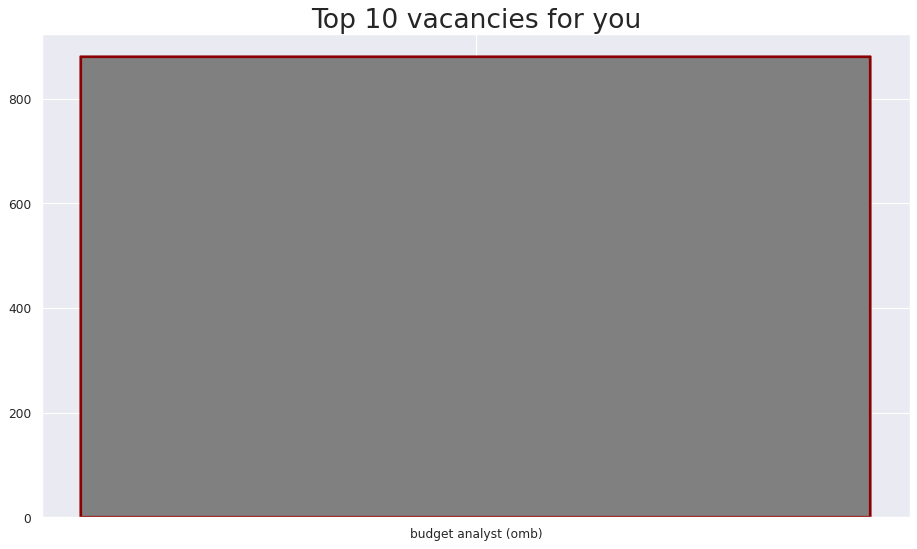

In [48]:
fig, ax = plt.subplots(figsize=(14,8), dpi= 80)
plt.title("Top 10 vacancies for you", fontsize=24)
plt.bar(x=df11["Civil Service Title"][:11].tolist(), height=df11["Compatibility, %"][:11], color="gray", edgecolor = "darkred", linewidth = 2);

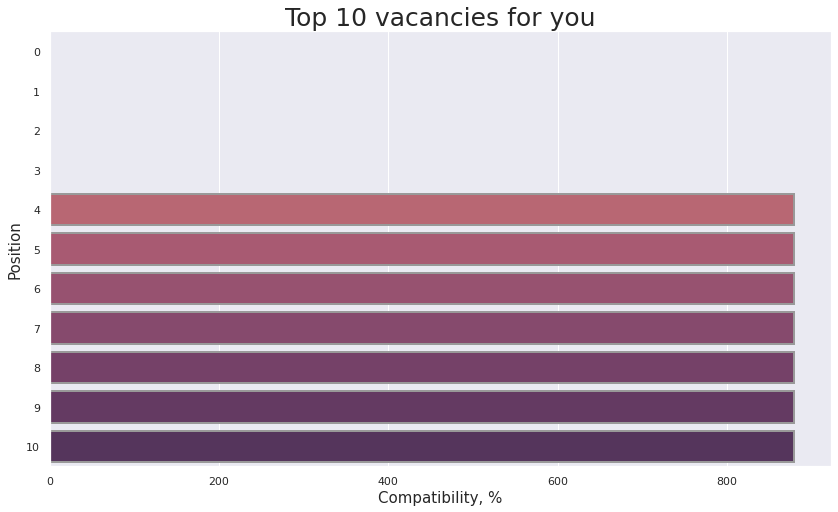

In [49]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14, 8)})
ax = sns.barplot(data=df11["Compatibility, %"][:11].tolist(), orient="h", linewidth=2, palette = "flare", saturation=.6, edgecolor=".6")
plt.ylabel("Position", fontsize = 15)
plt.xlabel("Compatibility, %", fontsize = 15)
plt.title("Top 10 vacancies for you", fontsize = 25)
plt.show()

## Skill based salary calculation

In [50]:
x = df.drop(columns=["Salary annual", "Job Description", "Minimum Qual Requirements"])
x = pd.get_dummies(x)
y = df["Salary annual"]
x["# Of Positions"] = x["# Of Positions"].astype("int")
x["NumUniqueNgrams"] = x["NumUniqueNgrams"].astype("int")

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import  SGD, Adadelta
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

### HistGradientBoostingRegressor

In [53]:
# hgb = HistGradientBoostingRegressor(learning_rate=0.5, max_depth=150, max_leaf_nodes=50, max_iter=400, scoring="r2", random_state=44)
# hgb.fit(x_train, y_train)
# preds = hgb.predict(x_test)

In [54]:
# print('MAE: %.0f' % mean_absolute_error(y_test, preds))
# print('R^2: %.2f' % r2_score(y_test, preds))

### Keras Feed-Forward Neural Network

In [55]:
def build_nn():
  model = Sequential()
  model.add(Dense(300, kernel_initializer='glorot_normal', input_shape = (x_train.shape[1],)))
  model.add(Dropout(0.4))
  model.add(Dense(280, kernel_initializer='glorot_normal', activation='selu'))
  model.add(Dropout(0.4))
  model.add(Dense(260, kernel_initializer='glorot_normal', activation='selu'))
  model.add(Dropout(0.4))
  model.add(Dense(240, kernel_initializer='glorot_normal', activation='selu'))
  model.add(Dropout(0.4))
  model.add(Dense(220, kernel_initializer='glorot_normal', activation='selu'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = 'selu'))
  optim = optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer = optim, loss = 'mean_absolute_error', metrics = ['mae'])
  return model

In [56]:
model = build_nn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               2937900   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 280)               84280     
_________________________________________________________________
dropout_6 (Dropout)          (None, 280)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 260)               73060     
_________________________________________________________________
dropout_7 (Dropout)          (None, 260)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 240)              

In [57]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), verbose=0, batch_size = 10, epochs = 300)

In [58]:
preds = model.predict(x_test)
mae = mean_absolute_error(preds, y_test)
r2 = r2_score(preds, y_test)

In [59]:
print('MAE: %.0f' % mae)
print('R^2: %.2f' % r2)

MAE: 7271
R^2: 0.62


In [60]:
def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(14,6))
    ax1.plot(loss, label='Train')
    ax1.plot(val_loss, label='Test')
    ax1.legend(loc='center')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

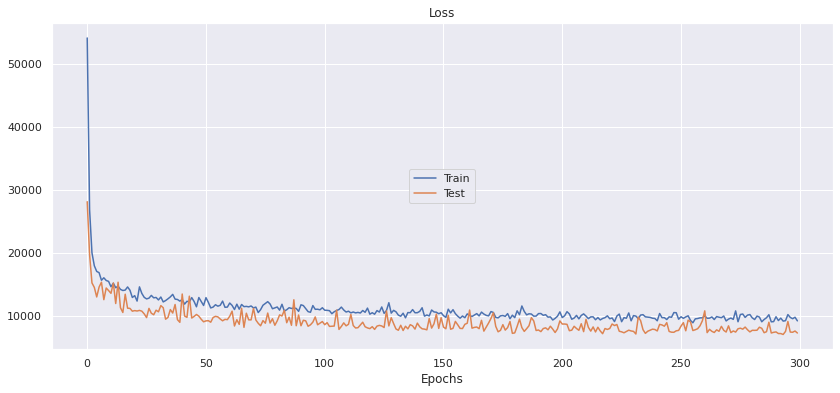

In [61]:
plot_metrics(history.history['loss'], history.history['val_loss'])

## EDA

In [62]:
e = df["Salary annual"].describe()
print("Average salary is", round(e[1]), "USD")
print("Median salary is", round(e[5]), "USD")

Average salary is 77859 USD
Median salary is 76737 USD


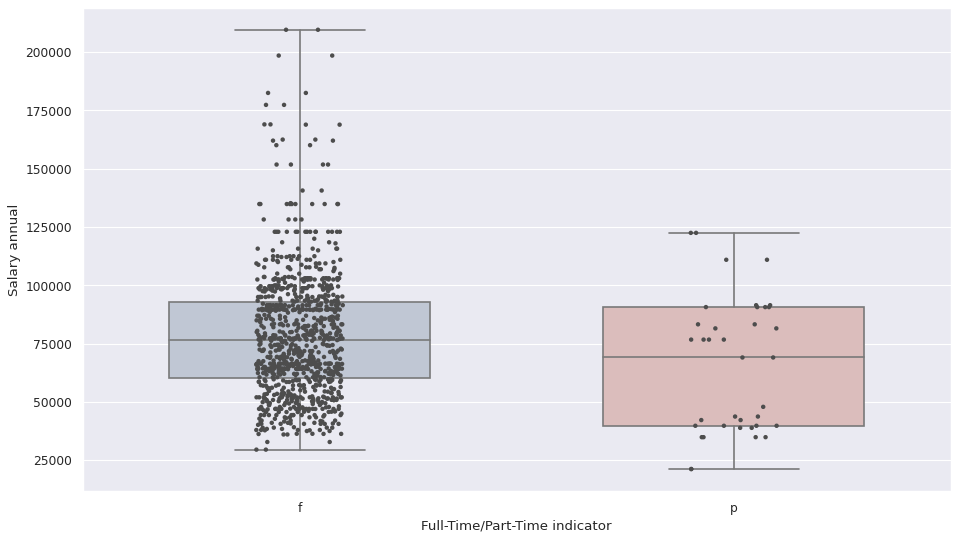

In [63]:
fig, ax = plt.subplots(figsize=(14,8), dpi= 80)
sns.boxplot(x="Full-Time/Part-Time indicator", y="Salary annual", data=df,whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="Full-Time/Part-Time indicator", y="Salary annual", data=df,
              size=4, color=".3", linewidth=0)

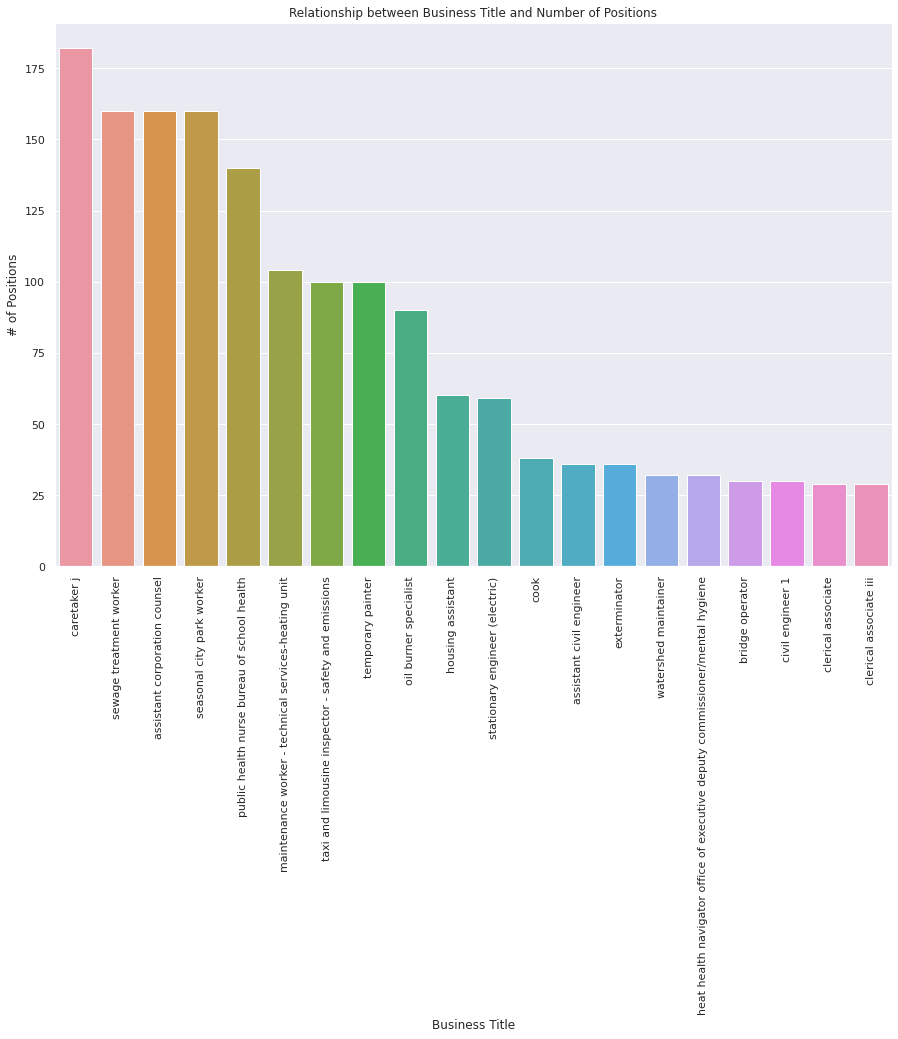

In [64]:
number_of_position = {}
for title,np in zip(df["Business Title"],df["# Of Positions"]):
    if title in number_of_position.keys():
        number_of_position[title] += np
    else:
        number_of_position[title] = np
        
columns = [*number_of_position.keys()]
positions = [*number_of_position.values()]

df = pd.DataFrame({"Business Title":columns,"# of positions":positions})
newIndex = (df["# of positions"].sort_values(ascending = False)).index.values
sortedData = df.reindex(newIndex)

plt.figure(figsize = (15,10))
ax = sns.barplot(x = sortedData["Business Title"][0:20],y = sortedData["# of positions"])
plt.xticks(rotation = 90)
plt.xlabel("Business Title")
plt.ylabel("# of Positions")
plt.title("Relationship between Business Title and Number of Positions")        
plt.show()